In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import datetime
from collections import OrderedDict 
import numpy
import csv

In [2]:
torch.cuda.empty_cache()

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
def show_sample():
    folder_dataset = dset.ImageFolder(root=Config.training_dir)
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
    dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            num_workers=0,
                            batch_size=8)
    dataiter = iter(dataloader)


    example_batch = next(dataiter)
    concatenated = torch.cat((example_batch[0],example_batch[1]),0)
    imshow(torchvision.utils.make_grid(concatenated))
    print(example_batch[2].numpy())

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self,no_of_layers):
        super(SiameseNetwork, self).__init__()
        layer=OrderedDict()
        
        layer[str(1)]=nn.ReflectionPad2d(1)
        layer[str(2)]=nn.Conv2d(1, 4, kernel_size=3)
        layer[str(3)]=nn.ReLU(inplace=True)
        layer[str(4)]=nn.BatchNorm2d(4)
        
        layer[str(5)]=nn.ReflectionPad2d(1)
        layer[str(6)]=nn.Conv2d(4, 8, kernel_size=3)
        layer[str(7)]=nn.ReLU(inplace=True)
        layer[str(8)]=nn.BatchNorm2d(8)
        
        z=8
        for i in range(no_of_layers):
            z=z+1
            layer[str(z)]=nn.ReflectionPad2d(1)
            z=z+1
            layer[str(z)]=nn.Conv2d(8, 8, kernel_size=3)
            z=z+1
            layer[str(z)]=nn.ReLU(inplace=True)
            z=z+1
            layer[str(z)]=nn.BatchNorm2d(8)
        
        self.cnn1 = nn.Sequential(layer)
        
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [8]:
class Loss_Function(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(Loss_Function, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss

In [9]:
def train_network(train_batch_size = 64,train_number_epochs = 100,learning_rate=0.05,no_of_layers=1,model_counter=0):
    
    torch.cuda.empty_cache()
    
    
    print("Loading Training Data...")
    folder_dataset = dset.ImageFolder(root=Config.training_dir)
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))
    train_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers=0,batch_size=train_batch_size)
    print("Building Model Architecure...")
    net = SiameseNetwork(no_of_layers).cuda()
    
    
    
    criterion = Loss_Function()
    optimizer = optim.Adam(net.parameters(),lr = learning_rate)
    counter = []
    loss_history = [] 
    iteration_number= 0
    print('Parameters:')
    print('Batch_Size:'+str(train_batch_size),
          'No_of_Epochs:'+str(train_number_epochs),
          'Learning_Rate:'+str(learning_rate),
          'Convolutional_Layers:'+str(no_of_layers+2)
         )
    #print('No of Epochs:'+str(train_number_epochs))
    #print('Learning Rate:'+str(learning_rate))
    #print('No of Convolutional Layers:'+str(no_of_layers))
    
    start=datetime.datetime.now()
    #print("Initializing Training at "+str(start))
    for epoch in range(0,train_number_epochs):
        if epoch% 10 ==0:
            if(epoch!=0):
                time_sec=(datetime.datetime.now()-start).total_seconds()
                #print("Epoch number {}\n Current loss {}\n".format(epoch,loss_history[-1]))
                #print('Time_Taken:'+str(time_sec)+" ,Time per Iteration: "+str(time_sec/epoch))
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %10 == 0 :
                #print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=1
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

    
    time_sec=(datetime.datetime.now()-start).total_seconds()
    print('Final Loss:'+str(loss_history[-1])+',Total Time Taken:'+str(time_sec)+" ,Average Time per Iteration: "+str(time_sec/train_number_epochs))

    show_plot(counter,loss_history)
    
    torch.save(net,"models/"+str(model_counter)+"_"+str(train_batch_size)+"_"+str(train_number_epochs)+"_"+str(learning_rate)+"_"+str(no_of_layers)+".pt")
    
    with open("csv/"+str(model_counter)+"_"+str(train_batch_size)+"_"+str(train_number_epochs)+"_"+str(learning_rate)+"_"+str(no_of_layers)+".csv", 'w') as f:
        writer = csv.writer(f)
        for count,loss in zip(counter,loss_history):
            writer.writerow([count, loss])
    
    
    del net,criterion,optimizer,train_dataloader
    torch.cuda.empty_cache()
    
    return loss_history[-1]
#loss=train_network(train_number_epochs=20)

Generation 1
Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:64 No_of_Epochs:100 Learning_Rate:0.05 Convolutional_Layers:3
Final Loss:2.0874133110046387,Total Time Taken:118.125287 ,Average Time per Iteration: 1.18125287


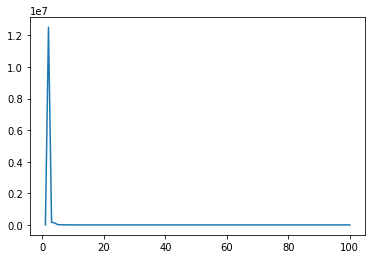

c:\program files\python36\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SiameseNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.005 Convolutional_Layers:4
Final Loss:1.628076434135437,Total Time Taken:304.661708 ,Average Time per Iteration: 1.52330854


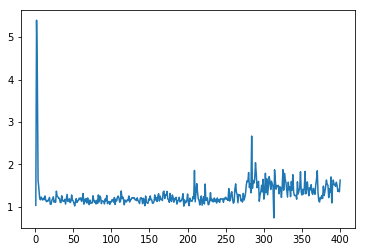

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:150 Learning_Rate:0.1 Convolutional_Layers:5
Final Loss:4.0385003089904785,Total Time Taken:394.95927 ,Average Time per Iteration: 2.6330618


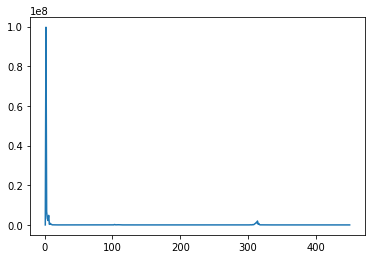

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:500 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.0867207050323486,Total Time Taken:1069.933078 ,Average Time per Iteration: 2.139866156


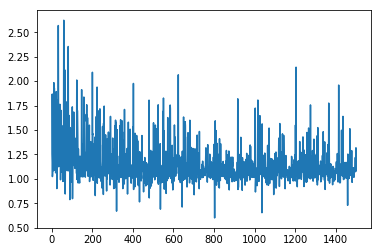

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:120 Learning_Rate:0.002 Convolutional_Layers:4
Final Loss:1.2080883979797363,Total Time Taken:182.578929 ,Average Time per Iteration: 1.521491075


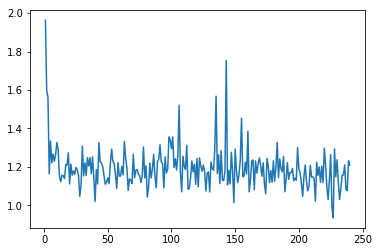

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:8 No_of_Epochs:300 Learning_Rate:0.04 Convolutional_Layers:4
Final Loss:1.152542233467102,Total Time Taken:1182.103146 ,Average Time per Iteration: 3.94034382


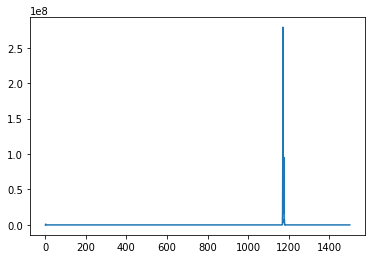

Fitness Results:
[6.4e+01 1.0e+02 5.0e-02 1.0e+00] 2.0874133110046387
[3.2e+01 2.0e+02 5.0e-03 2.0e+00] 1.628076434135437
[1.6e+01 1.5e+02 1.0e-01 3.0e+00] 4.0385003089904785
[1.6e+01 5.0e+02 1.0e-04 1.0e+00] 1.0867207050323486
[3.2e+01 1.2e+02 2.0e-03 2.0e+00] 1.2080883979797363
[8.e+00 3.e+02 4.e-02 2.e+00] 1.152542233467102
Selected Parents:
[[1.6e+01 5.0e+02 1.0e-04 1.0e+00]
 [8.0e+00 3.0e+02 4.0e-02 2.0e+00]
 [3.2e+01 1.2e+02 2.0e-03 2.0e+00]
 [3.2e+01 2.0e+02 5.0e-03 2.0e+00]
 [6.4e+01 1.0e+02 5.0e-02 1.0e+00]
 [1.6e+01 1.5e+02 1.0e-01 3.0e+00]]
Cross Over Points: 2 0
Cross Over Points: 0 1
Cross Over Points: 0 0
Cross Over Points: 1 1
Cross Over Points: 0 2
Cross Over Points: 2 2
Mutation Phase  2 :  [8.0e+00 1.5e+02 2.0e-03 2.0e+00]
Mutation Phase  2 :  [1.6e+01 1.0e+02 1.0e-04 1.0e+00]
Offspring:
[[1.6e+01 5.0e+02 4.0e-02 2.0e+00]
 [8.0e+00 3.0e+02 4.0e-02 2.0e+00]
 [3.2e+01 1.2e+02 2.0e-03 2.0e+00]
 [8.0e+00 1.5e+02 2.0e-03 2.0e+00]
 [3.2e+01 2.0e+02 5.0e-03 2.0e+00]
 [3.2e+0

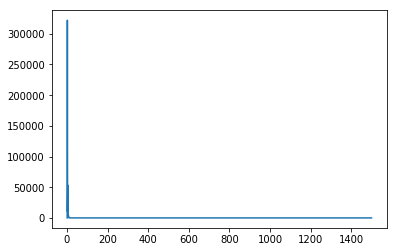

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:8 No_of_Epochs:300 Learning_Rate:0.04 Convolutional_Layers:4
Final Loss:1.4999966621398926,Total Time Taken:1168.949686 ,Average Time per Iteration: 3.896498953333333


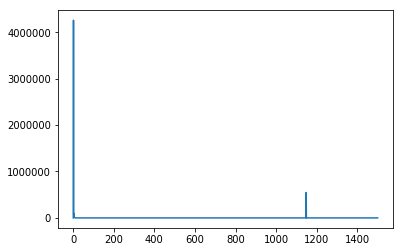

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:120 Learning_Rate:0.002 Convolutional_Layers:4
Final Loss:1.114175796508789,Total Time Taken:180.224363 ,Average Time per Iteration: 1.5018696916666667


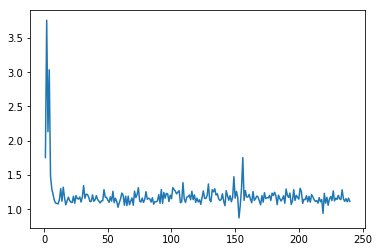

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:8 No_of_Epochs:150 Learning_Rate:0.002 Convolutional_Layers:4
Final Loss:1.0944960117340088,Total Time Taken:583.189409 ,Average Time per Iteration: 3.887929393333333


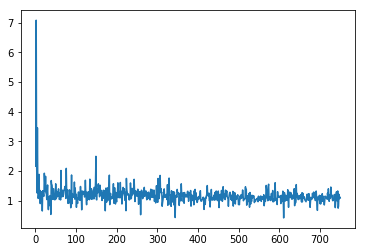

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.005 Convolutional_Layers:4
Final Loss:1.3249942064285278,Total Time Taken:301.466087 ,Average Time per Iteration: 1.507330435


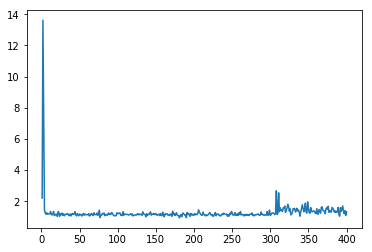

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.005 Convolutional_Layers:4
Final Loss:1.183790922164917,Total Time Taken:301.496438 ,Average Time per Iteration: 1.5074821900000002


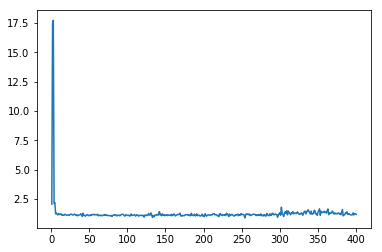

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:100 Learning_Rate:0.05 Convolutional_Layers:3
Final Loss:2.4361939430236816,Total Time Taken:130.1163 ,Average Time per Iteration: 1.3011629999999998


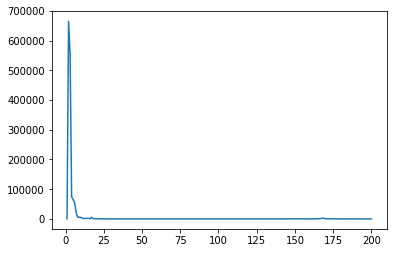

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:100 Learning_Rate:0.05 Convolutional_Layers:3
Final Loss:2.518681526184082,Total Time Taken:130.302114 ,Average Time per Iteration: 1.3030211399999998


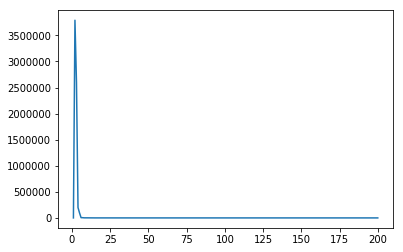

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:150 Learning_Rate:0.1 Convolutional_Layers:5
Final Loss:68.40785217285156,Total Time Taken:391.056599 ,Average Time per Iteration: 2.6070439933333334


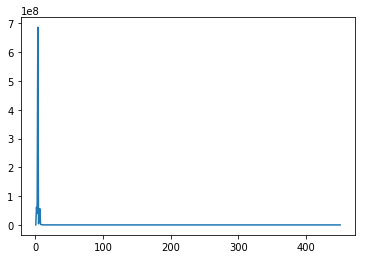

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:64 No_of_Epochs:100 Learning_Rate:0.1 Convolutional_Layers:5
Final Loss:24.84348487854004,Total Time Taken:137.617384 ,Average Time per Iteration: 1.3761738399999999


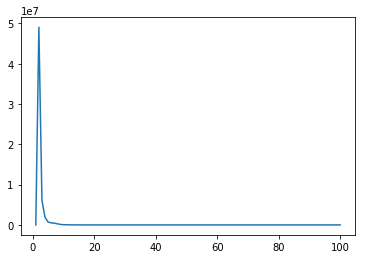

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:100 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.4110779762268066,Total Time Taken:212.161056 ,Average Time per Iteration: 2.12161056


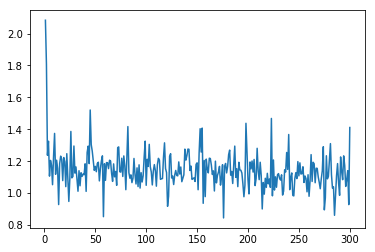

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:150 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.1051963567733765,Total Time Taken:317.281121 ,Average Time per Iteration: 2.1152074733333333


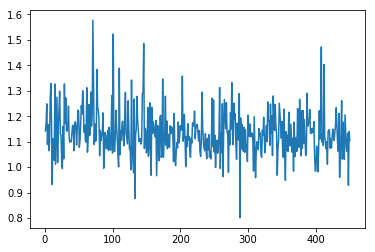

Fitness Results:
[1.6e+01 5.0e+02 4.0e-02 2.0e+00] 1.1146535873413086
[8.e+00 3.e+02 4.e-02 2.e+00] 1.4999966621398926
[3.2e+01 1.2e+02 2.0e-03 2.0e+00] 1.114175796508789
[8.0e+00 1.5e+02 2.0e-03 2.0e+00] 1.0944960117340088
[3.2e+01 2.0e+02 5.0e-03 2.0e+00] 1.3249942064285278
[3.2e+01 2.0e+02 5.0e-03 2.0e+00] 1.183790922164917
[3.2e+01 1.0e+02 5.0e-02 1.0e+00] 2.4361939430236816
[3.2e+01 1.0e+02 5.0e-02 1.0e+00] 2.518681526184082
[1.6e+01 1.5e+02 1.0e-01 3.0e+00] 68.40785217285156
[ 64.  100.    0.1   3. ] 24.84348487854004
[1.6e+01 1.0e+02 1.0e-04 1.0e+00] 1.4110779762268066
[1.6e+01 1.5e+02 1.0e-04 1.0e+00] 1.1051963567733765
Selected Parents:
[[8.0e+00 1.5e+02 2.0e-03 2.0e+00]
 [1.6e+01 1.5e+02 1.0e-04 1.0e+00]
 [3.2e+01 1.2e+02 2.0e-03 2.0e+00]
 [1.6e+01 5.0e+02 4.0e-02 2.0e+00]
 [3.2e+01 2.0e+02 5.0e-03 2.0e+00]
 [3.2e+01 2.0e+02 5.0e-03 2.0e+00]]
Cross Over Points: 0 2
Cross Over Points: 0 2
Cross Over Points: 2 0
Cross Over Points: 1 2
Cross Over Points: 1 2
Cross Over Points: 2

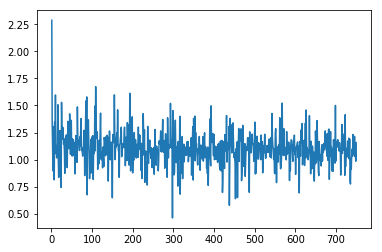

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:8 No_of_Epochs:150 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.1558746099472046,Total Time Taken:551.039445 ,Average Time per Iteration: 3.6735963


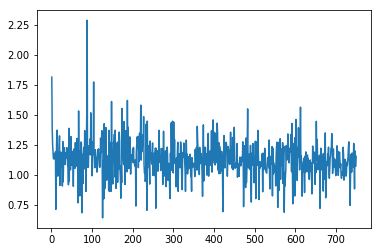

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:120 Learning_Rate:0.002 Convolutional_Layers:4
Final Loss:1.1736825704574585,Total Time Taken:182.740796 ,Average Time per Iteration: 1.5228399666666665


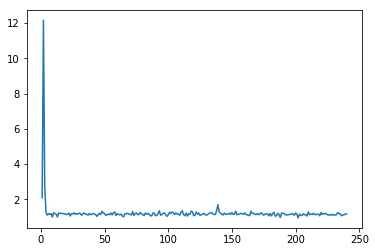

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:150 Learning_Rate:0.002 Convolutional_Layers:4
Final Loss:1.190148949623108,Total Time Taken:355.509837 ,Average Time per Iteration: 2.37006558


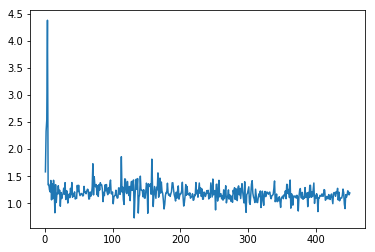

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:120 Learning_Rate:0.04 Convolutional_Layers:4
Final Loss:3.3029510974884033,Total Time Taken:181.324097 ,Average Time per Iteration: 1.5110341416666666


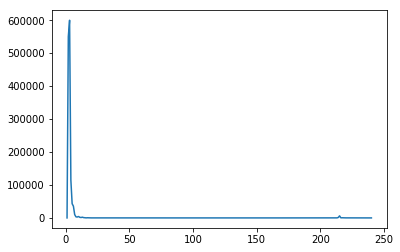

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:500 Learning_Rate:0.04 Convolutional_Layers:4
Final Loss:1.749996304512024,Total Time Taken:1193.232761 ,Average Time per Iteration: 2.386465522


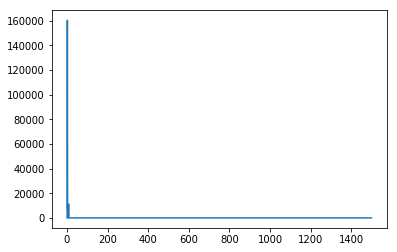

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:200 Learning_Rate:0.005 Convolutional_Layers:4
Final Loss:2.2499940395355225,Total Time Taken:476.45641 ,Average Time per Iteration: 2.38228205


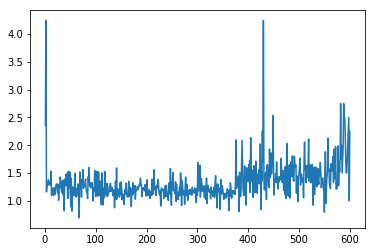

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:500 Learning_Rate:0.005 Convolutional_Layers:4
Final Loss:1.0561151504516602,Total Time Taken:1191.829523 ,Average Time per Iteration: 2.383659046


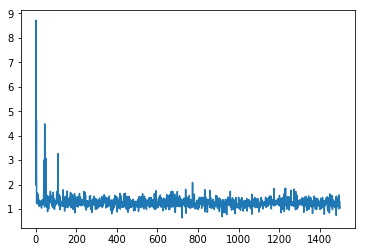

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.005 Convolutional_Layers:4
Final Loss:1.8749960660934448,Total Time Taken:303.509264 ,Average Time per Iteration: 1.51754632


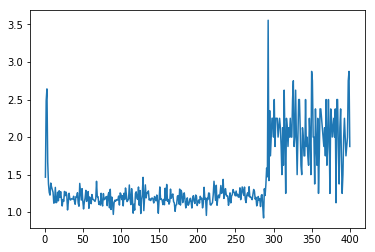

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.005 Convolutional_Layers:4
Final Loss:1.1048574447631836,Total Time Taken:303.453282 ,Average Time per Iteration: 1.51726641


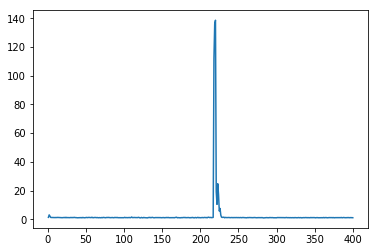

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.002 Convolutional_Layers:4
Final Loss:1.0497950315475464,Total Time Taken:303.930159 ,Average Time per Iteration: 1.519650795


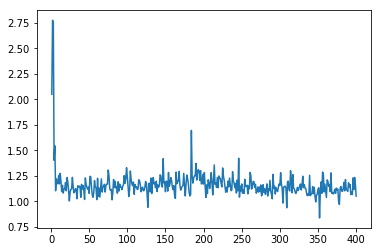

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.002 Convolutional_Layers:4
Final Loss:1.1240980625152588,Total Time Taken:299.62066 ,Average Time per Iteration: 1.4981033


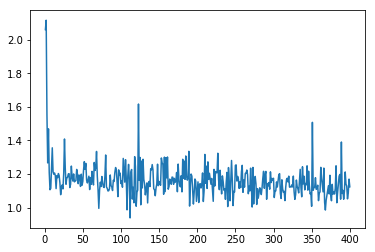

Fitness Results:
[8.0e+00 1.5e+02 1.0e-04 1.0e+00] 1.1566437482833862
[8.0e+00 1.5e+02 1.0e-04 1.0e+00] 1.1558746099472046
[3.2e+01 1.2e+02 2.0e-03 2.0e+00] 1.1736825704574585
[1.6e+01 1.5e+02 2.0e-03 2.0e+00] 1.190148949623108
[3.2e+01 1.2e+02 4.0e-02 2.0e+00] 3.3029510974884033
[1.6e+01 5.0e+02 4.0e-02 2.0e+00] 1.749996304512024
[1.6e+01 2.0e+02 5.0e-03 2.0e+00] 2.2499940395355225
[1.6e+01 5.0e+02 5.0e-03 2.0e+00] 1.0561151504516602
[3.2e+01 2.0e+02 5.0e-03 2.0e+00] 1.8749960660934448
[3.2e+01 2.0e+02 5.0e-03 2.0e+00] 1.1048574447631836
[3.2e+01 2.0e+02 2.0e-03 2.0e+00] 1.0497950315475464
[3.2e+01 2.0e+02 2.0e-03 2.0e+00] 1.1240980625152588
Selected Parents:
[[3.2e+01 2.0e+02 2.0e-03 2.0e+00]
 [1.6e+01 5.0e+02 5.0e-03 2.0e+00]
 [3.2e+01 2.0e+02 5.0e-03 2.0e+00]
 [3.2e+01 2.0e+02 2.0e-03 2.0e+00]
 [8.0e+00 1.5e+02 1.0e-04 1.0e+00]
 [8.0e+00 1.5e+02 1.0e-04 1.0e+00]]
Cross Over Points: 1 1
Cross Over Points: 2 2
Cross Over Points: 1 2
Cross Over Points: 2 1
Cross Over Points: 2 2
Cross

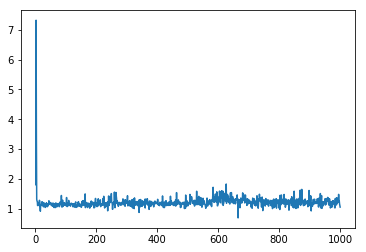

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:500 Learning_Rate:0.005 Convolutional_Layers:4
Final Loss:1.1795953512191772,Total Time Taken:749.1067 ,Average Time per Iteration: 1.4982134


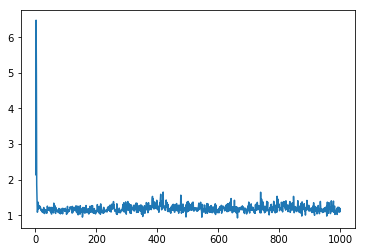

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:500 Learning_Rate:0.0001 Convolutional_Layers:4
Final Loss:1.0989999771118164,Total Time Taken:1174.193921 ,Average Time per Iteration: 2.348387842


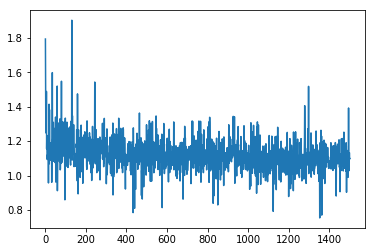

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:500 Learning_Rate:0.005 Convolutional_Layers:4
Final Loss:2.2499945163726807,Total Time Taken:1176.492856 ,Average Time per Iteration: 2.352985712


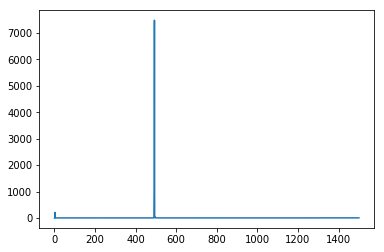

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.002 Convolutional_Layers:5
Final Loss:1.0639748573303223,Total Time Taken:339.000058 ,Average Time per Iteration: 1.69500029


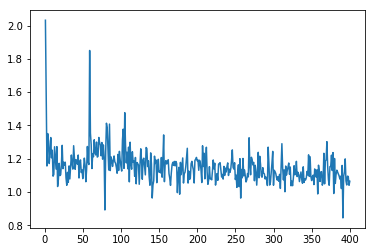

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.002 Convolutional_Layers:4
Final Loss:1.1584339141845703,Total Time Taken:299.346252 ,Average Time per Iteration: 1.49673126


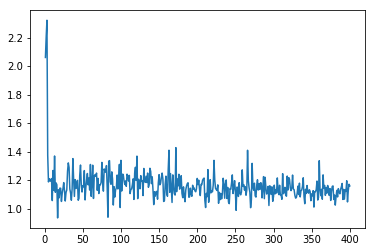

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.110323429107666,Total Time Taken:257.983315 ,Average Time per Iteration: 1.2899165750000001


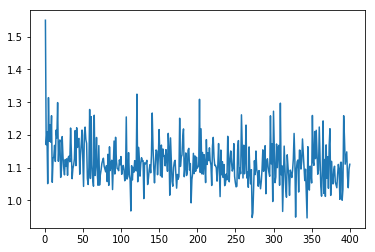

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:150 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.1795556545257568,Total Time Taken:193.465664 ,Average Time per Iteration: 1.2897710933333333


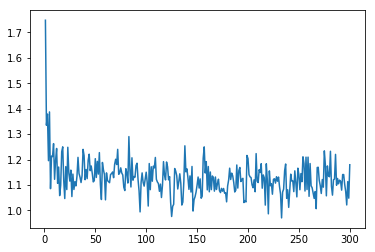

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:8 No_of_Epochs:150 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.0935953855514526,Total Time Taken:539.847764 ,Average Time per Iteration: 3.5989850933333334


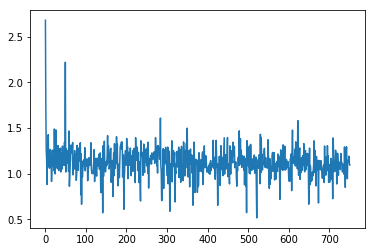

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:8 No_of_Epochs:150 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:0.9324960708618164,Total Time Taken:540.133271 ,Average Time per Iteration: 3.6008884733333337


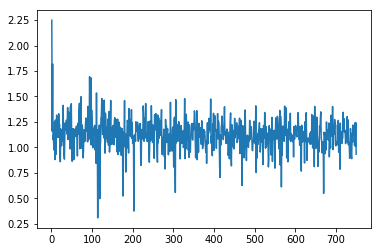

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:8 No_of_Epochs:150 Learning_Rate:0.002 Convolutional_Layers:4
Final Loss:1.2995109558105469,Total Time Taken:599.186851 ,Average Time per Iteration: 3.994579006666667


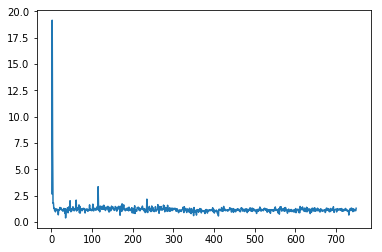

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.002 Convolutional_Layers:4
Final Loss:1.2036348581314087,Total Time Taken:300.250987 ,Average Time per Iteration: 1.501254935


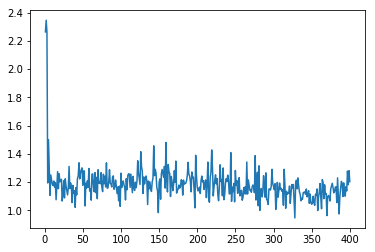

Fitness Results:
[3.2e+01 5.0e+02 5.0e-03 2.0e+00] 1.05190908908844
[3.2e+01 5.0e+02 5.0e-03 2.0e+00] 1.1795953512191772
[1.6e+01 5.0e+02 1.0e-04 2.0e+00] 1.0989999771118164
[1.6e+01 5.0e+02 5.0e-03 2.0e+00] 2.2499945163726807
[3.2e+01 2.0e+02 2.0e-03 3.0e+00] 1.0639748573303223
[3.2e+01 2.0e+02 2.0e-03 2.0e+00] 1.1584339141845703
[3.2e+01 2.0e+02 1.0e-04 1.0e+00] 1.110323429107666
[3.2e+01 1.5e+02 1.0e-04 1.0e+00] 1.1795556545257568
[8.0e+00 1.5e+02 1.0e-04 1.0e+00] 1.0935953855514526
[8.0e+00 1.5e+02 1.0e-04 1.0e+00] 0.9324960708618164
[8.0e+00 1.5e+02 2.0e-03 2.0e+00] 1.2995109558105469
[3.2e+01 2.0e+02 2.0e-03 2.0e+00] 1.2036348581314087
Selected Parents:
[[8.0e+00 1.5e+02 1.0e-04 1.0e+00]
 [3.2e+01 5.0e+02 5.0e-03 2.0e+00]
 [3.2e+01 2.0e+02 2.0e-03 3.0e+00]
 [8.0e+00 1.5e+02 1.0e-04 1.0e+00]
 [1.6e+01 5.0e+02 1.0e-04 2.0e+00]
 [3.2e+01 2.0e+02 1.0e-04 1.0e+00]]
Cross Over Points: 2 0
Cross Over Points: 1 0
Cross Over Points: 0 1
Cross Over Points: 0 0
Cross Over Points: 1 2
Cross 

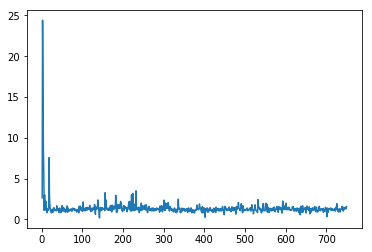

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:500 Learning_Rate:0.005 Convolutional_Layers:4
Final Loss:1.4379191398620605,Total Time Taken:778.234798 ,Average Time per Iteration: 1.556469596


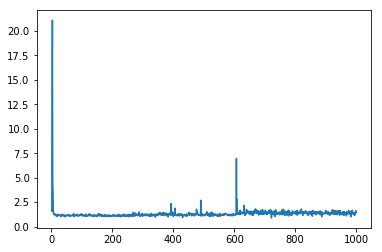

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.002 Convolutional_Layers:5
Final Loss:1.1107207536697388,Total Time Taken:351.294417 ,Average Time per Iteration: 1.756472085


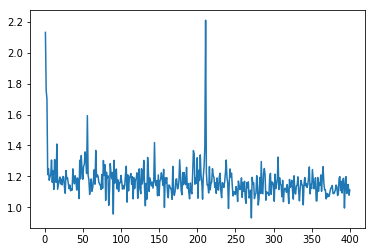

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.002 Convolutional_Layers:5
Final Loss:1.1676486730575562,Total Time Taken:349.552933 ,Average Time per Iteration: 1.747764665


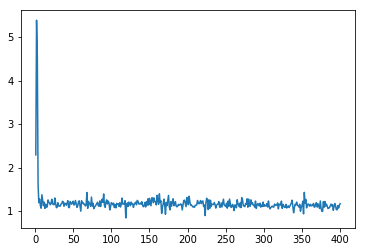

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:8 No_of_Epochs:150 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.0612494945526123,Total Time Taken:563.410161 ,Average Time per Iteration: 3.75606774


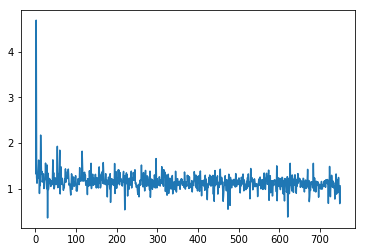

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:150 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.1644421815872192,Total Time Taken:199.076265 ,Average Time per Iteration: 1.3271751


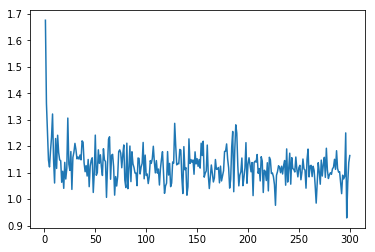

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:500 Learning_Rate:0.0001 Convolutional_Layers:4
Final Loss:0.9864811897277832,Total Time Taken:1193.182045 ,Average Time per Iteration: 2.38636409


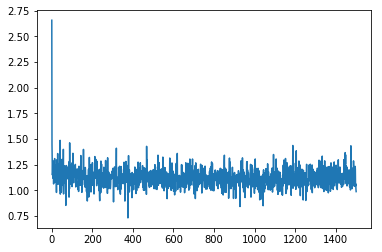

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:500 Learning_Rate:0.0001 Convolutional_Layers:4
Final Loss:1.1632623672485352,Total Time Taken:1170.171695 ,Average Time per Iteration: 2.34034339


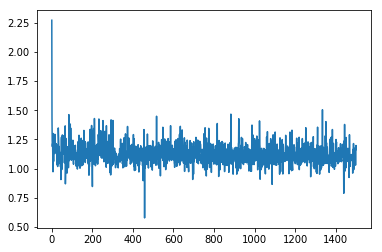

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:200 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.25929594039917,Total Time Taken:420.714306 ,Average Time per Iteration: 2.10357153


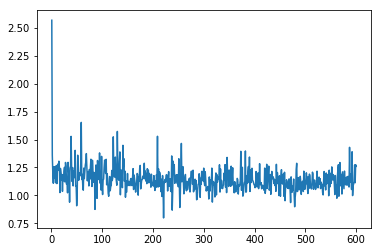

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:16 No_of_Epochs:500 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.1002063751220703,Total Time Taken:1053.210325 ,Average Time per Iteration: 2.10642065


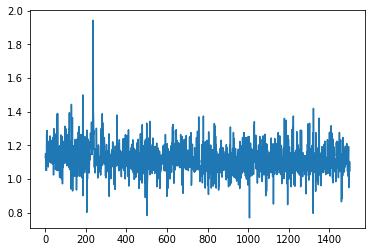

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.1896589994430542,Total Time Taken:257.835944 ,Average Time per Iteration: 1.28917972


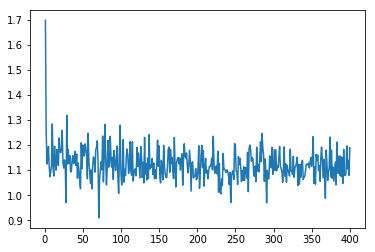

Loading Training Data...
Building Model Architecure...
Parameters:
Batch_Size:32 No_of_Epochs:200 Learning_Rate:0.0001 Convolutional_Layers:3
Final Loss:1.1785506010055542,Total Time Taken:257.71075 ,Average Time per Iteration: 1.2885537500000002


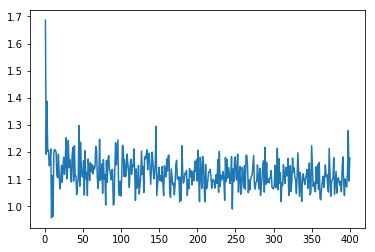

Fitness Results:
[8.0e+00 1.5e+02 5.0e-03 2.0e+00] 1.5497188568115234
[3.2e+01 5.0e+02 5.0e-03 2.0e+00] 1.4379191398620605
[3.2e+01 2.0e+02 2.0e-03 3.0e+00] 1.1107207536697388
[3.2e+01 2.0e+02 2.0e-03 3.0e+00] 1.1676486730575562
[8.0e+00 1.5e+02 1.0e-04 1.0e+00] 1.0612494945526123
[3.2e+01 1.5e+02 1.0e-04 1.0e+00] 1.1644421815872192
[1.6e+01 5.0e+02 1.0e-04 2.0e+00] 0.9864811897277832
[1.6e+01 5.0e+02 1.0e-04 2.0e+00] 1.1632623672485352
[1.6e+01 2.0e+02 1.0e-04 1.0e+00] 1.25929594039917
[1.6e+01 5.0e+02 1.0e-04 1.0e+00] 1.1002063751220703
[3.2e+01 2.0e+02 1.0e-04 1.0e+00] 1.1896589994430542
[3.2e+01 2.0e+02 1.0e-04 1.0e+00] 1.1785506010055542
Selected Parents:
[[1.6e+01 5.0e+02 1.0e-04 2.0e+00]
 [8.0e+00 1.5e+02 1.0e-04 1.0e+00]
 [1.6e+01 5.0e+02 1.0e-04 1.0e+00]
 [3.2e+01 2.0e+02 2.0e-03 3.0e+00]
 [1.6e+01 5.0e+02 1.0e-04 2.0e+00]
 [3.2e+01 1.5e+02 1.0e-04 1.0e+00]]
Cross Over Points: 1 1
Cross Over Points: 1 1
Cross Over Points: 1 0
Cross Over Points: 1 0
Cross Over Points: 1 0
Cross

In [10]:
population=np.array([[64,100,0.05,1],
       [32,200,0.005,2]
        ,[16,150,0.1,3]
        ,[16,500,0.0001,1]
        ,[32,120,0.002,2]
        ,[8,300,0.04,2]
      ])
batch_list=[64,32,16,8]
epoch_list=[100,120,210,150,200,300,500]
alpha_list=[0.005,0.05,0.1,0.0001,0.002,0.04]


def get_fitness_value(parameters,model_counter):
    loss=train_network(int(parameters[0]),int(parameters[1]),parameters[2],int(parameters[3]),model_counter)
    return loss

def select_suitable_parents(population,fitness,population_size):
    selected_parents=np.zeros(population_size)
    for i in range(population_size[0]):
        max_fitness_index=np.where(fitness==min(fitness))
        max_fitness_index=max_fitness_index[0][0]
        selected_parents[i,:]=population[max_fitness_index,:]
        fitness[max_fitness_index]=99999999
    return selected_parents

def crossover(parents,population_size):
    x=[0,1,2]
    offsprings=np.zeros([population_size[0]*2,population_size[1]])
    
    step=0
    for k in range(population_size[0]):
        random.shuffle(x)
        offspring_1_cross_pt=x[0]
        random.shuffle(x)
        offspring_2_cross_pt=x[0]
        print('Cross Over Points:',offspring_1_cross_pt,offspring_2_cross_pt)
        parent1_idx = k%parents.shape[0]
        
        parent2_idx = (k+1)%parents.shape[0]
         
        offsprings[step, 0:offspring_1_cross_pt] = parents[parent1_idx, 0:offspring_1_cross_pt]
        offsprings[step, offspring_1_cross_pt:] = parents[parent2_idx, offspring_1_cross_pt:]
        step=step+1
        
        offsprings[step, 0:offspring_2_cross_pt] = parents[parent1_idx, 0:offspring_2_cross_pt]
        offsprings[step, offspring_2_cross_pt:] = parents[parent2_idx, offspring_2_cross_pt:]
        step=step+1
    return offsprings
    
def mutation(offspring):
    for i,each in enumerate(offspring):
        if(random.randint(0,100)<5):
            choice=random.randint(1,4)
            if(choice==1):
                offspring[i][0]=random.choice(batch_list)
                print("Mutation Phase ",choice,": ", offspring[i])    
            if(choice==2):
                offspring[i][1]=random.choice(epoch_list)
                print("Mutation Phase ",choice,": ", offspring[i])    
            if(choice==3):
                offspring[i][2]=random.choice(alpha_list)
                print("Mutation Phase ",choice,": ", offspring[i])    
            if(choice==4):
                offspring[i][3]=random.randint(1,3)
                print("Mutation Phase ",choice,": ", offspring[i])    
            
    return offspring
    
    
def run_genetic_algorithm(population,no_of_generations=5):
    model_counter=0
    
    no_of_parameters=4
    population_size=[len(population),no_of_parameters]
    fixed_population_size=population_size
    for each in range(no_of_generations):
        print('Generation '+str(each+1))
        
        fitness=np.zeros(population_size[0])
        for i in range(population_size[0]):
            model_counter=model_counter+1
            fitness[i]=get_fitness_value(population[i],model_counter)
        print('Fitness Results:')
        for pop,fit in zip(population,fitness.tolist()):
            print(pop,str(fit))
            
        selected_parents=select_suitable_parents(population,fitness,fixed_population_size)
        print('Selected Parents:')
        print(selected_parents)
        offspring=crossover(selected_parents,fixed_population_size)
        offspring=mutation(offspring)
        population_size=[len(offspring),no_of_parameters]
        population=offspring
        print('Offspring:')
        print(offspring)
    
run_genetic_algorithm(population)

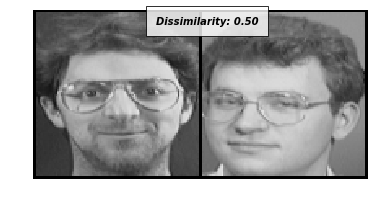

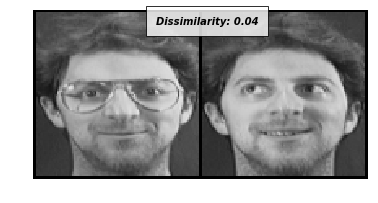

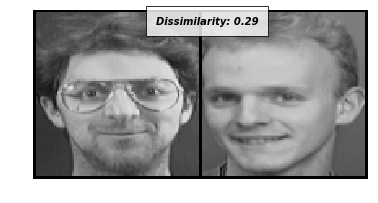

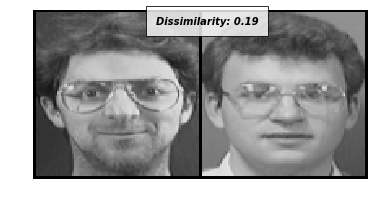

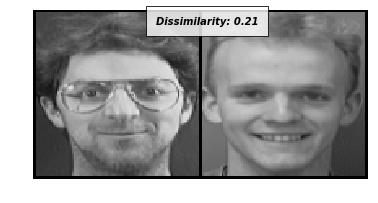

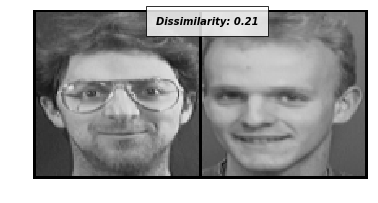

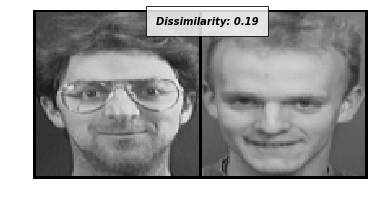

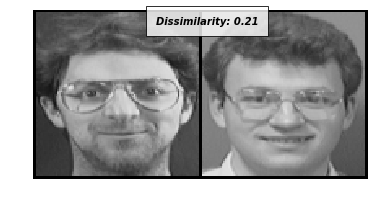

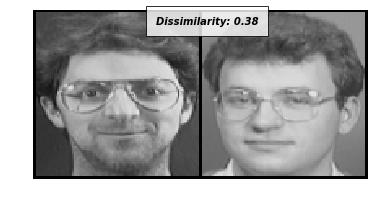

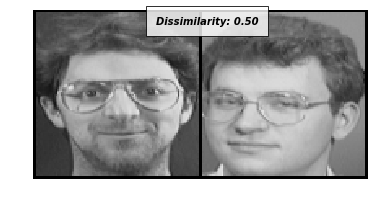

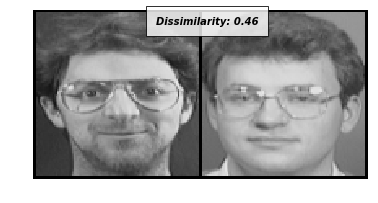

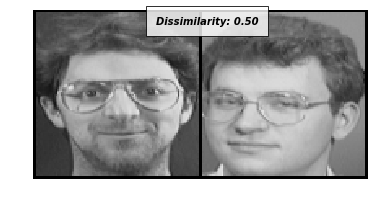

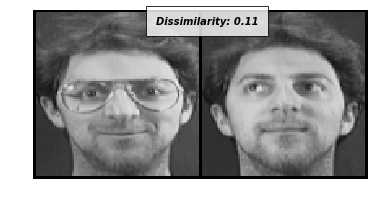

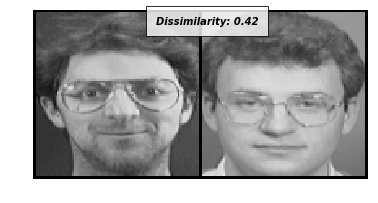

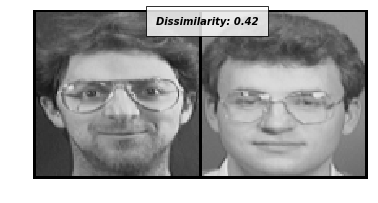

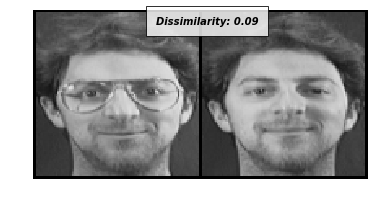

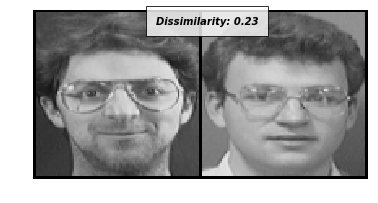

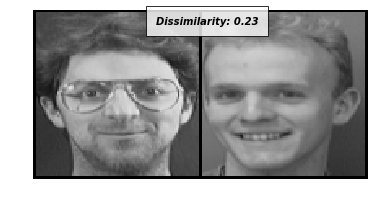

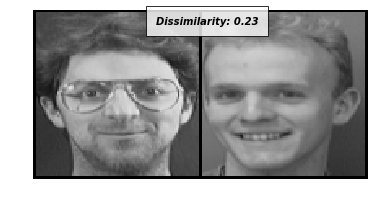

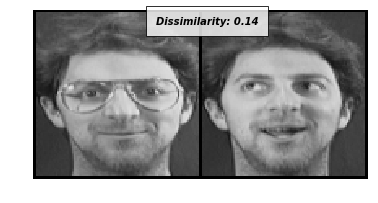

In [43]:
net = SiameseNetwork(1).cuda()
net = torch.load("50_16_500_0.0001_2.pt")
net.eval()
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(20):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

